LSTM网络非线性关系分析
使用分号作为分隔符成功加载数据
数据形状: (12936, 16)
使用以下列进行分析:
  - 日期列: Date
  - 情感列: Compound_Score
  - 价格列: Close
转换日期列 'Date' 为日期时间类型...
数据中存在缺失值，进行填充...
训练集形状: (10324, 30, 2), 测试集形状: (2582, 30, 2)

情景1: 使用LSTM预测价格
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
价格预测结果:
  - MSE: 21305.6003
  - RMSE: 145.9644
  - R²: 0.9870


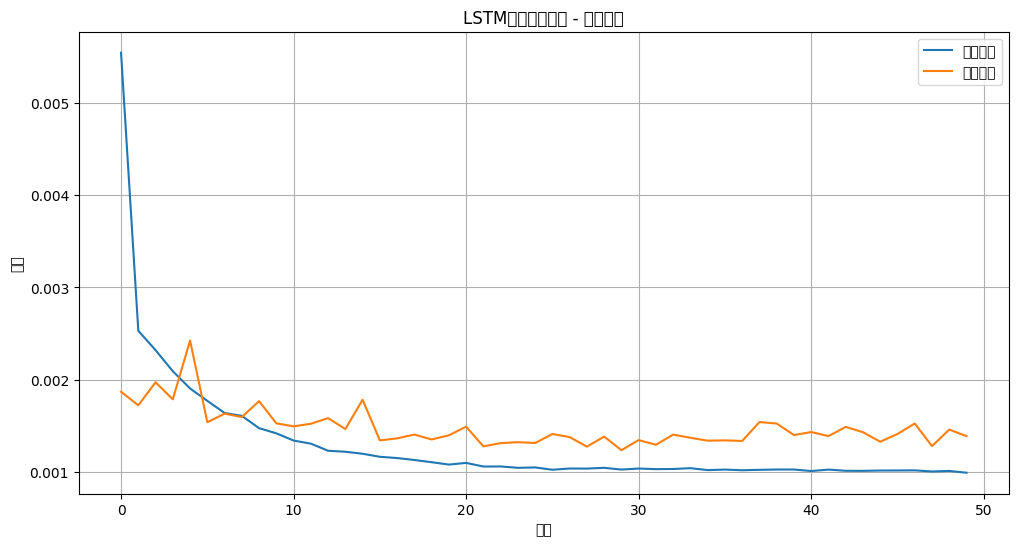

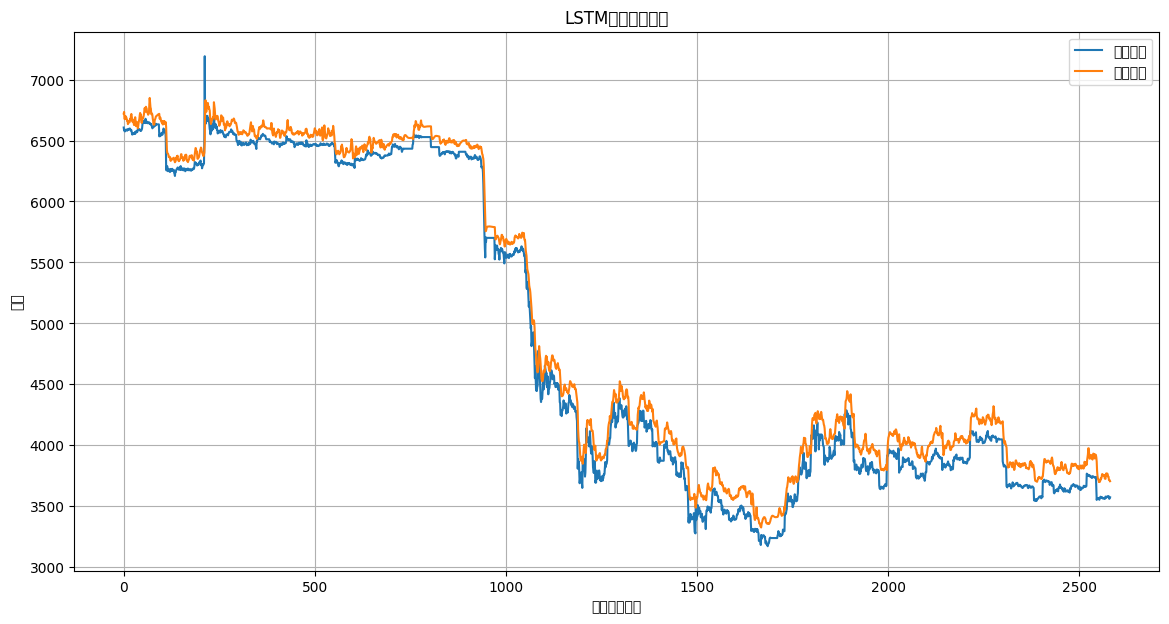


情景2: 使用LSTM预测情感
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
情感预测结果:
  - MSE: 0.0010
  - RMSE: 0.0314
  - R²: 0.4461


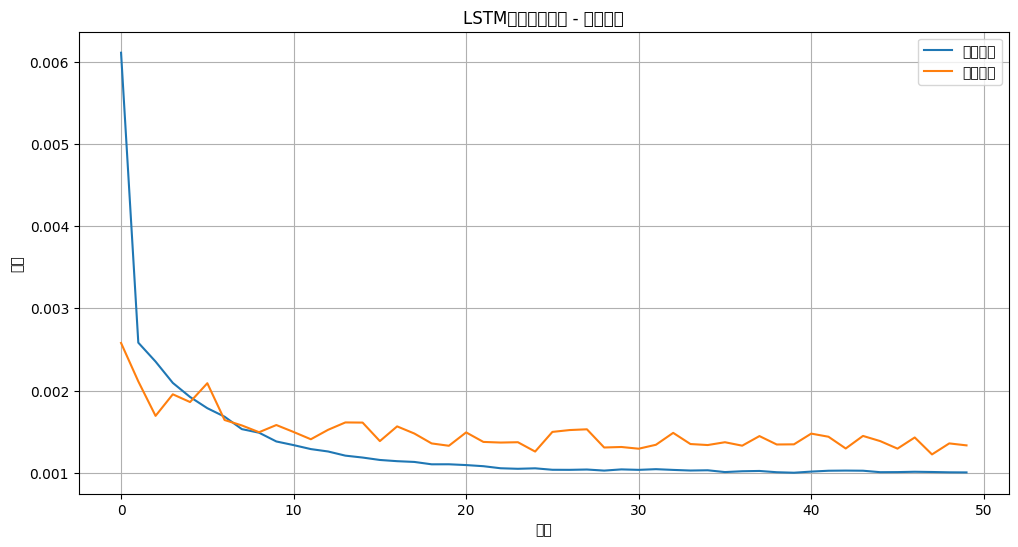

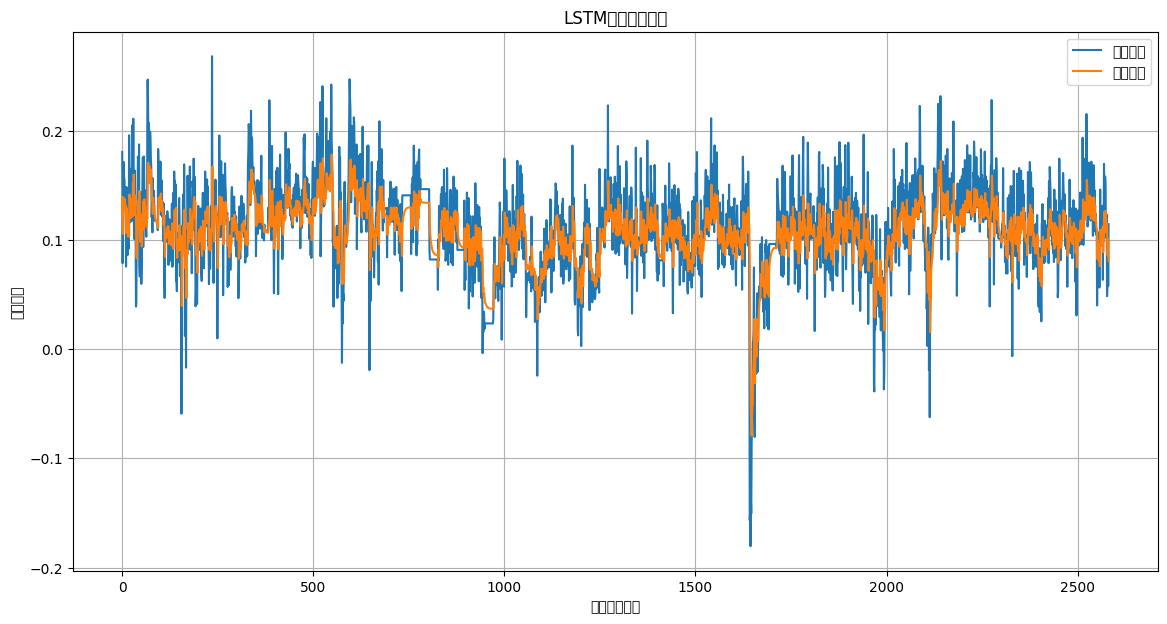


LSTM模型比较:
价格预测的R²: 0.9870
情感预测的R²: 0.4461
LSTM模型在预测价格方面表现更好，这表明综合历史情感和价格数据可能对预测未来价格更有效。


In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def lstm_analysis(filepath):
    """
    使用LSTM网络探索价格和情感之间的非线性关系
    
    参数:
    filepath: 数据文件路径
    """
    print("="*80)
    print("LSTM网络非线性关系分析")
    print("="*80)
    
    # 加载数据
    try:
        # 尝试不同的分隔符
        try:
            df = pd.read_csv(filepath, sep=';', encoding='utf-8')
            print(f"使用分号作为分隔符成功加载数据")
        except:
            df = pd.read_csv(filepath, encoding='utf-8')
            print(f"使用默认分隔符成功加载数据")
        
        print(f"数据形状: {df.shape}")
    except Exception as e:
        print(f"加载数据失败: {e}")
        return None
    
    # 查找关键列
    date_cols = [col for col in df.columns if any(term in col.lower() for term in ['date', 'time'])]
    sentiment_cols = [col for col in df.columns if any(term in col.lower() for term in 
                     ['sentiment', 'compound', 'score', 'positive', 'negative'])]
    price_cols = [col for col in df.columns if any(term in col.lower() for term in 
                 ['price', 'close', 'open', 'high', 'low'])]
    
    # 验证找到了必要的列
    if not (date_cols and sentiment_cols and price_cols):
        print("缺少必要的列（日期、情感或价格）。请检查数据结构。")
        print("可用列: ", df.columns.tolist())
        return None
    
    # 选择要使用的主要列
    date_col = date_cols[0]
    sentiment_col = [col for col in sentiment_cols if 'compound' in col.lower() or 'score' in col.lower()]
    sentiment_col = sentiment_col[0] if sentiment_col else sentiment_cols[0]
    price_col = [col for col in price_cols if 'close' in col.lower()]
    price_col = price_col[0] if price_col else price_cols[0]
    
    print(f"使用以下列进行分析:")
    print(f"  - 日期列: {date_col}")
    print(f"  - 情感列: {sentiment_col}")
    print(f"  - 价格列: {price_col}")
    
    # 确保日期列是日期时间类型
    if df[date_col].dtype != 'datetime64[ns]':
        print(f"转换日期列 '{date_col}' 为日期时间类型...")
        try:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        except Exception as e:
            print(f"日期转换失败: {e}")
            return None
    
    # 按日期排序
    df = df.sort_values(by=date_col)
    
    # 选择要使用的特征列
    selected_cols = [sentiment_col, price_col]
    data = df[selected_cols].copy()
    
    # 检查并处理缺失值
    if data.isnull().sum().any():
        print(f"数据中存在缺失值，进行填充...")
        data = data.fillna(method='ffill').fillna(method='bfill')
    
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # 创建LSTM所需的序列数据
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    # 使用过去30天的数据预测下一天
    sequence_length = 30
    
    # 只有在数据点足够的情况下才继续
    if len(scaled_data) > sequence_length:
        X, y = create_sequences(scaled_data, sequence_length)
        
        # 划分训练集和测试集 - 使用最后20%的数据作为测试集
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        print(f"训练集形状: {X_train.shape}, 测试集形状: {X_test.shape}")
        
        # 构建LSTM模型 - 预测价格
        print("\n情景1: 使用LSTM预测价格")
        
        # 取出价格所在的列索引
        price_idx = 1 if price_col == selected_cols[1] else 0
        
        # 创建模型
        model_price = Sequential()
        model_price.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
        model_price.add(Dropout(0.2))
        model_price.add(LSTM(50))
        model_price.add(Dropout(0.2))
        model_price.add(Dense(y_train.shape[1]))
        
        model_price.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # 训练模型
        history_price = model_price.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        
        # 评估模型
        y_pred_price = model_price.predict(X_test)
        
        # 提取价格列进行评估
        y_test_price = y_test[:, price_idx]
        y_pred_price = y_pred_price[:, price_idx]
        
        # 反归一化
        y_test_price_orig = scaler.inverse_transform(np.hstack([np.zeros((len(y_test_price), 1)), y_test_price.reshape(-1, 1)]))[:, 1]
        y_pred_price_orig = scaler.inverse_transform(np.hstack([np.zeros((len(y_pred_price), 1)), y_pred_price.reshape(-1, 1)]))[:, 1]
        
        # 计算评估指标
        mse_price = mean_squared_error(y_test_price_orig, y_pred_price_orig)
        rmse_price = np.sqrt(mse_price)
        r2_price = r2_score(y_test_price_orig, y_pred_price_orig)
        
        print(f"价格预测结果:")
        print(f"  - MSE: {mse_price:.4f}")
        print(f"  - RMSE: {rmse_price:.4f}")
        print(f"  - R²: {r2_price:.4f}")
        
        # 绘制训练历史
        plt.figure(figsize=(12, 6))
        plt.plot(history_price.history['loss'], label='训练损失')
        plt.plot(history_price.history['val_loss'], label='验证损失')
        plt.title('LSTM模型训练历史 - 价格预测')
        plt.xlabel('周期')
        plt.ylabel('损失')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 绘制预测结果
        plt.figure(figsize=(14, 7))
        plt.plot(y_test_price_orig, label='实际价格')
        plt.plot(y_pred_price_orig, label='预测价格')
        plt.title('LSTM价格预测结果')
        plt.xlabel('测试集时间步')
        plt.ylabel('价格')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 构建LSTM模型 - 预测情感
        print("\n情景2: 使用LSTM预测情感")
        
        # 取出情感所在的列索引
        sentiment_idx = 0 if sentiment_col == selected_cols[0] else 1
        
        # 创建模型
        model_sentiment = Sequential()
        model_sentiment.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
        model_sentiment.add(Dropout(0.2))
        model_sentiment.add(LSTM(50))
        model_sentiment.add(Dropout(0.2))
        model_sentiment.add(Dense(y_train.shape[1]))
        
        model_sentiment.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        
        # 训练模型
        history_sentiment = model_sentiment.fit(
            X_train, y_train,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            verbose=0
        )
        
        # 评估模型
        y_pred_sentiment = model_sentiment.predict(X_test)
        
        # 提取情感列进行评估
        y_test_sentiment = y_test[:, sentiment_idx]
        y_pred_sentiment = y_pred_sentiment[:, sentiment_idx]
        
        # 反归一化
        zeros_array = np.zeros((len(y_test_sentiment), 1))
        scaled_test = np.zeros((len(y_test_sentiment), 2))
        scaled_test[:, sentiment_idx] = y_test_sentiment
        
        scaled_pred = np.zeros((len(y_pred_sentiment), 2))
        scaled_pred[:, sentiment_idx] = y_pred_sentiment
        
        y_test_sentiment_orig = scaler.inverse_transform(scaled_test)[:, sentiment_idx]
        y_pred_sentiment_orig = scaler.inverse_transform(scaled_pred)[:, sentiment_idx]
        
        # 计算评估指标
        mse_sentiment = mean_squared_error(y_test_sentiment_orig, y_pred_sentiment_orig)
        rmse_sentiment = np.sqrt(mse_sentiment)
        r2_sentiment = r2_score(y_test_sentiment_orig, y_pred_sentiment_orig)
        
        print(f"情感预测结果:")
        print(f"  - MSE: {mse_sentiment:.4f}")
        print(f"  - RMSE: {rmse_sentiment:.4f}")
        print(f"  - R²: {r2_sentiment:.4f}")
        
        # 绘制训练历史
        plt.figure(figsize=(12, 6))
        plt.plot(history_sentiment.history['loss'], label='训练损失')
        plt.plot(history_sentiment.history['val_loss'], label='验证损失')
        plt.title('LSTM模型训练历史 - 情感预测')
        plt.xlabel('周期')
        plt.ylabel('损失')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 绘制预测结果
        plt.figure(figsize=(14, 7))
        plt.plot(y_test_sentiment_orig, label='实际情感')
        plt.plot(y_pred_sentiment_orig, label='预测情感')
        plt.title('LSTM情感预测结果')
        plt.xlabel('测试集时间步')
        plt.ylabel('情感得分')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # 模型比较
        print("\nLSTM模型比较:")
        print(f"价格预测的R²: {r2_price:.4f}")
        print(f"情感预测的R²: {r2_sentiment:.4f}")
        
        if r2_price > r2_sentiment:
            print("LSTM模型在预测价格方面表现更好，这表明综合历史情感和价格数据可能对预测未来价格更有效。")
        else:
            print("LSTM模型在预测情感方面表现更好，这表明综合历史情感和价格数据可能对预测未来情感更有效。")
        
        return {
            'model_price': model_price,
            'model_sentiment': model_sentiment,
            'r2_price': r2_price,
            'r2_sentiment': r2_sentiment
        }
    else:
        print(f"数据点不足，需要至少 {sequence_length + 1} 个数据点，但只有 {len(scaled_data)} 个")
        return None

# 调用函数进行LSTM分析
lstm_results = lstm_analysis('../dataset/df_Final.csv')